# Walmart Sales: Exploratory Data Analysis  

In this notebook I carried out a basic exploratory data analysis (EDA) on the Wallmart sales data [Kaggle competition](https://www.kaggle.com/competitions/walmart-sales-forecasting/overview) to:  
- Identify the number of samples and variables
- Identify the kinds of variables available
- Define if data is to be cleaned/imputed based on missing values
- Explore data to reveal patterns which may explain output of model
- Identify if there are any strongly correlated variables
- Define the pre-processing to be done on categorical/numerical variables
- Define if the target variable needs any pre-processing

## Table of Contents  
1. Basic data description  
2. Variable reformatting  
3. Variable exploration  
4. Variable relationships  
5. Weekly Sales in detail  
6. EDA conclusions

## Import libraries


In [1]:
import pandas as pd
import numpy as np

import datetime
import calendar

import seaborn as sns
import matplotlib.pyplot as plt

# Import my own functions
from src.data.data_processing import convert_date_fn, group_df_agg_fn
from src.visualization.visualize import palette_20

# Plotting config
sns.set_theme(style="white")

## Import data

In [2]:
# Import raw data
data_raw_df=pd.read_csv("data/raw/Walmart_Store_sales.csv")
print("There are {} samples and {} variables present in the data".format(data_raw_df.shape[0], data_raw_df.shape[1]))
data_raw_df.head()

There are 150 samples and 8 variables present in the data


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


## Data dictionary

In [3]:
data_raw_dic=pd.read_csv("references/Walmart_Store_sales_dictionary.txt")
data_raw_dic

,variable,description
0,Store,the store number
1,Date,the week
2,Weekly_Sales,sales for the given department in the given store
3,Holiday_Flag,whether the week is a special holiday week
4,Temperature,average temperature in the region (in Fahrenheit)
5,Fuel_Price,cost of fuel in the region
6,CPI,the consumer price index
7,Unemployment,the unemployment rate


## 1. Basic data description

### Variable types

In [4]:
#Check the data type of each variable and get idea of number of non-null variables
data_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


### Data description: statistics

In [5]:
# Look at distribution of variable
data_raw_df.describe(include='all')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


### Missing values

In [6]:
# Number and percentage of missing values. Sort samples by highest percentage of missing values
dict_missing_vals = {"variable" : data_raw_df.columns.tolist(), "total_missing_vals":data_raw_df.isnull().sum().tolist(), "per_missing_vals": (100*data_raw_df.isnull().sum()/data_raw_df.shape[0]).tolist() }

pd.DataFrame(dict_missing_vals).sort_values(by=['per_missing_vals'], ascending=False)


,variable,total_missing_vals,per_missing_vals
1,Date,18,12.000000
4,Temperature,18,12.000000
7,Unemployment,15,10.000000
2,Weekly_Sales,14,9.333333
5,Fuel_Price,14,9.333333
3,Holiday_Flag,12,8.000000
6,CPI,12,8.000000
0,Store,0,0.000000


### Target variable distribution: Weekly Sales  
Visualize in more detail distribution of the target variable (Weekly Sales)

(150, 8)
(136, 8)
Quantile distribution of Weekly Sales
 0.00    2.689290e+05
0.25    6.050757e+05
0.50    1.261424e+06
0.75    1.806386e+06
1.00    2.771397e+06
Name: Weekly_Sales, dtype: float64


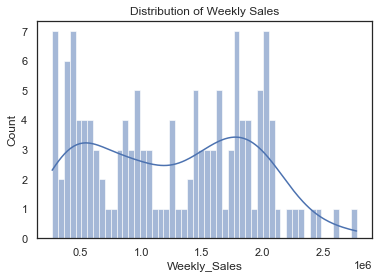

In [7]:
# Plot distribution of weekly sales

# Create copy of raw dataframe without null values
data_df = data_raw_df.copy()
data_df.dropna(subset=['Weekly_Sales'], inplace=True)

print(data_raw_df.shape)
print(data_df.shape)

# Print quantile for Weekly Sales
print('Quantile distribution of Weekly Sales\n', data_df['Weekly_Sales'].quantile([0,0.25,0.5,0.75,1]))

# Histogram of weekly sales distribution
fig = sns.histplot(data_df, x="Weekly_Sales", bins=52, kde=True)
fig.set(title='Distribution of Weekly Sales')

# Export image in results
plt.savefig('results/01-EDA_target_variable_distribution.png', bbox_inches='tight')

## 2. Variable reformatting

### Reformat date variable

In [8]:
# Convert Date variable format (string) to explore its relationship to other variables:
# Extract day of the week, month etc

# Dataframe of converted datetime. Keep missing date values
data_reformat_df= convert_date_fn(data_df,datecol='Date')
data_reformat_df.head()

,Store,date,dayofweek,dayofweek_en,quarter,month,month_en,year,dayofyear,dayofmonth,weekofyear,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,2011-02-18,4.0,Friday,1.0,2.0,Feb,2011.0,49.0,18.0,7,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,2011-03-25,4.0,Friday,1.0,3.0,Mar,2011.0,84.0,25.0,12,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,11.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,1244390.03,0.0,84.57,NaN,214.556497,7.346
3,6.0,2010-05-28,4.0,Friday,2.0,5.0,May,2010.0,148.0,28.0,21,1644470.66,0.0,78.89,2.759,212.412888,7.092
4,4.0,2010-05-28,4.0,Friday,2.0,5.0,May,2010.0,148.0,28.0,21,1857533.70,0.0,NaN,2.756,126.160226,7.896


In [9]:
# Check extracted datetime variables type
data_reformat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 135
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         136 non-null    float64       
 1   date          118 non-null    datetime64[ns]
 2   dayofweek     118 non-null    float64       
 3   dayofweek_en  118 non-null    object        
 4   quarter       118 non-null    float64       
 5   month         118 non-null    float64       
 6   month_en      118 non-null    object        
 7   year          118 non-null    float64       
 8   dayofyear     118 non-null    float64       
 9   dayofmonth    118 non-null    float64       
 10  weekofyear    118 non-null    UInt32        
 11  Weekly_Sales  136 non-null    float64       
 12  Holiday_Flag  125 non-null    float64       
 13  Temperature   121 non-null    float64       
 14  Fuel_Price    124 non-null    float64       
 15  CPI           125 non-null    float64   

### Reformat temperature

In [10]:
# Change temperature from Fahrenheit to Celsius for better understanding
data_reformat_df['Temperature'] = (data_reformat_df['Temperature'] - 32) * 5/9

print('Temperature range (°C)\n', data_reformat_df['Temperature'].describe())

Temperature range (°C)
 count    121.000000
mean      16.029982
std       10.285795
min       -7.338889
25%        7.344444
50%       16.805556
75%       24.416667
max       33.138889
Name: Temperature, dtype: float64


In [11]:
# Export reformatted data

# Create Store string ID 
data_reformat_df['Store_str'] = [str(store) for store in data_reformat_df.Store.tolist()]


data_reformat_df.to_csv('data/interim/Walmart_Store_sales.csv')

## 3. Variable exploration

### Holiday Flag

In [12]:
# How many holiday flags?
print("There are {} holiday flags".format(len(data_reformat_df[data_reformat_df['Holiday_Flag']==1])))

# Months most represented for holidays:
print('Months with most holiday flags\n', data_reformat_df[data_reformat_df['Holiday_Flag']==1]['month'].value_counts().sort_values(ascending=False))



There are 9 holiday flags
Months with most holiday flags
 2.0     4
9.0     2
12.0    1
11.0    1
Name: month, dtype: int64


### Visualize all variable distributions

Distribution of variables after reformatting of date and temp


/var/folders/xt/m7dn4ld978gb2yvlx1htgxx40000gn/T/ipykernel_2080/1470323680.py:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_reformat_df.hist(ax = ax)


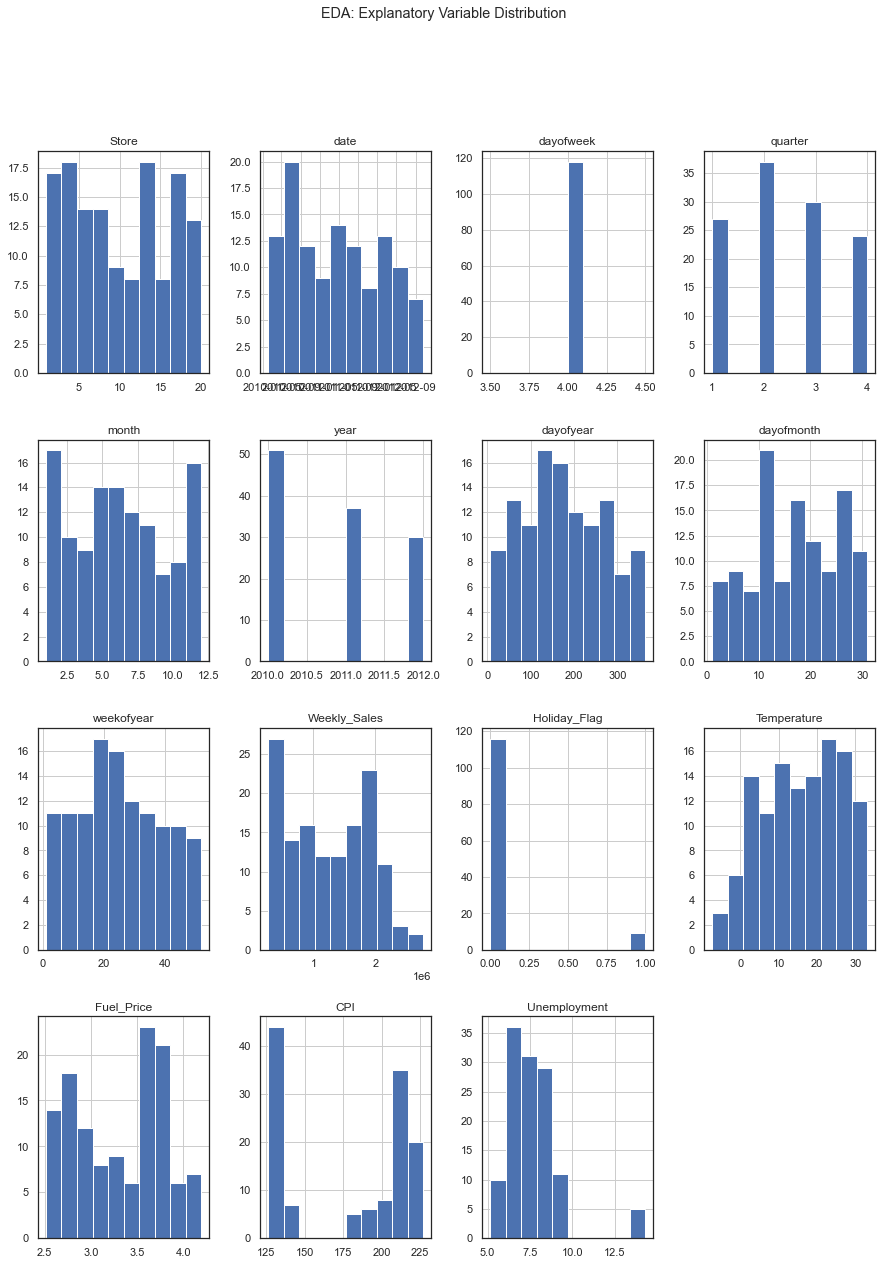

In [13]:
# Visualize variable distributions after datetime conversion

# Set size for figure
fig = plt.figure(figsize = (15,20))
# Get axes instance
ax = fig.gca()

# Plot histograms for all data variables
print("Distribution of variables after reformatting of date and temp")
data_reformat_df.hist(ax = ax)

# Export image in results
plt.suptitle("EDA: Explanatory Variable Distribution")
plt.savefig('results/01-EDA_explanatory_variables_distribution.png', bbox_inches='tight')


In [14]:
# Check unique day of week: Friday
# This is coherent since they report weekly sales (described in Kaggle competition summary)
data_reformat_df.dayofweek_en.unique()

array(['Friday', nan], dtype=object)

In [15]:
# We observe that 2010 has almost all entries for the 52 weeks of the year
data_reformat_df.year.value_counts()

2010.0    51
2011.0    37
2012.0    30
Name: year, dtype: int64

[Text(0.5, 1.0, 'Frequency of months: order by most frequent'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Count')]

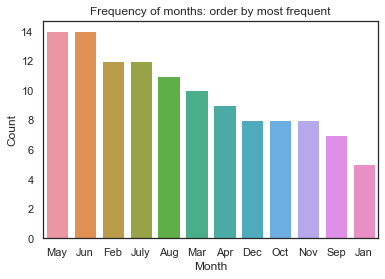

In [16]:
# Better visualize months with most entries
fig = sns.countplot(x="month_en", data=data_reformat_df, order = data_reformat_df['month_en'].value_counts(ascending=False).index)
fig.set(title='Frequency of months: order by most frequent', xlabel='Month', ylabel='Count')

## 4. Variable relationships

,Store,quarter,month,year,dayofyear,dayofmonth,weekofyear,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000,-0.047518,-0.022525,-0.056383,-0.029973,-0.028090,-0.031562,0.127980,-0.061869,-0.257807,0.220081,-0.551569,0.264960
quarter,-0.047518,1.000000,0.969723,-0.224266,0.965719,-0.042250,0.965885,-0.093883,-0.054429,0.291993,-0.126524,0.020610,-0.085660
month,-0.022525,0.969723,1.000000,-0.243397,0.995871,-0.034040,0.996133,-0.062015,-0.032562,0.302267,-0.142484,0.005926,-0.080812
year,-0.056383,-0.224266,-0.243397,1.000000,-0.260892,-0.114404,-0.243456,-0.017743,-0.043659,-0.139389,0.806108,0.139684,-0.147336
dayofyear,-0.029973,0.965719,0.995871,-0.260892,1.000000,0.049402,0.999702,-0.061927,-0.036901,0.309254,-0.163953,0.022160,-0.085026


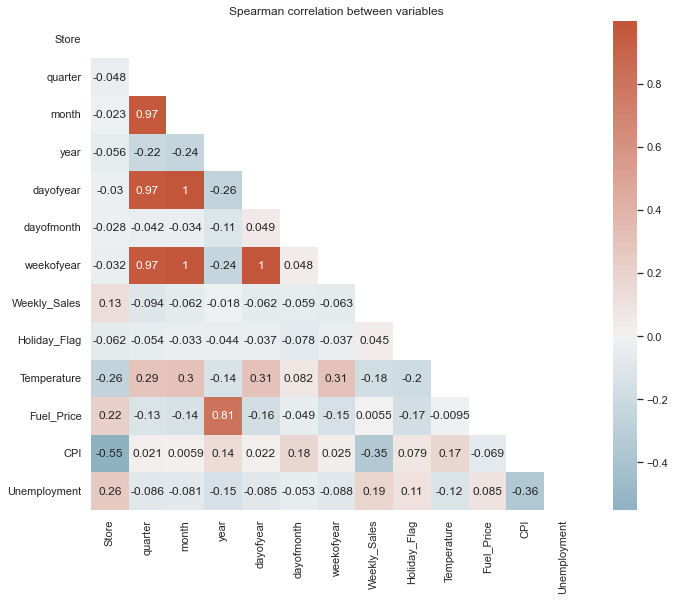

In [37]:
# #Explore possible correlation between variables

# Drop dayofweek as it is an unique value
data_corr = data_reformat_df.drop('dayofweek', axis=1)

# Correlation matrix
data_corr = data_corr.corr(method="spearman")
display(data_corr.head())

# Plot diagonal corr matrix (see seaborn documentation for example)
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
hm=sns.heatmap(data_corr, mask=mask, cmap=cmap,center=0,annot=True)

hm.set(title='Spearman correlation between variables')

plt.show()

# Export image in results
fig = hm.get_figure()
fig.savefig('results/01-EDA_variables_corr.png', bbox_inches='tight') 

#plt.savefig('results/01-EDA_explanatory_variables_corr.png', bbox_inches='tight')

### Year vs Fuel Price

[Text(0.5, 1.0, 'Years vs Fuel Price')]

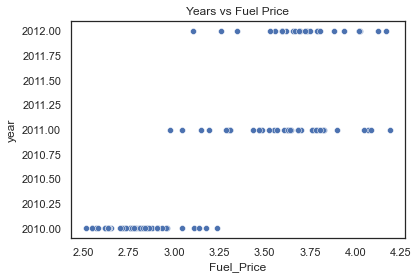

In [18]:
fig = sns.scatterplot(x="Fuel_Price", y="year",data=data_reformat_df)
fig.set(title = 'Years vs Fuel Price')

### Quarter vs Temperature

[Text(0.5, 1.0, 'Temperature vs Quarter')]

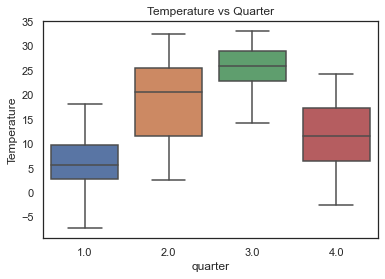

In [19]:
fig = sns.boxplot(x="quarter", y="Temperature",data=data_reformat_df)
fig.set(title = 'Temperature vs Quarter')

### Temprature vs weekly sales

### CPI and Unemployment

In [20]:
# Reprint meaning of CPI and Unemployment from data dictionary
data_raw_dic['description'][data_raw_dic.variable.isin(["CPI", "Unemployment"])]

6    the consumer price index
7       the unemployment rate
Name: description, dtype: object

More details about the CPI (Consumer Price Index) on [wikipedia](https://en.wikipedia.org/wiki/Consumer_price_index). The higher the value, the higher the inflation

#### CPI and Unemployment per year  
Evaluate if there could be differences throughout years, potentially explaining differences in sales

[Text(0.5, 1.0, 'Unemployment per year')]

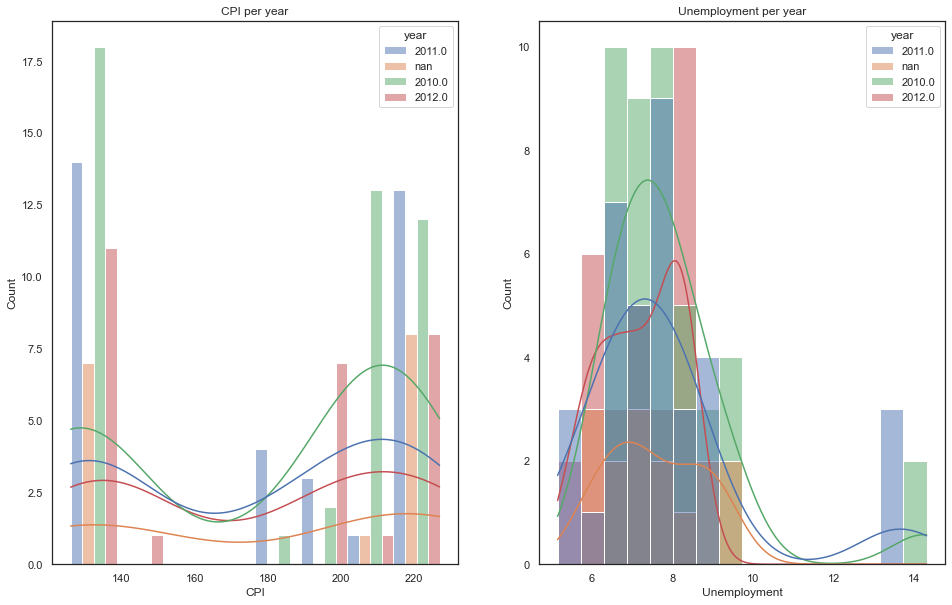

In [21]:
# Create copy of dataframe for plotting
df_plot =  data_reformat_df.copy()
# Convert year to string
df_plot['year'] = [str(Year) for Year in df_plot.year.tolist()]

# Set axes for grid and figure size
figure, axes = plt.subplots(1, 2, figsize=(16,10))


# Figure 1: weekly sales vs month, all stores
fig1 = sns.histplot(data=df_plot, x="CPI", hue="year", kde=True, multiple='dodge', ax=axes[0])
fig1.set(title = 'CPI per year')

# Figure 2 : weekly sales vs month per store
fig2 = sns.histplot(data=df_plot, x="Unemployment", hue="year", kde=True, ax=axes[1])
fig2.set(title = 'Unemployment per year')


In [22]:
# Median unemployment rate per year
group_df_agg_fn(data_reformat_df, group_col='year', col_eval='Unemployment', aggfn='median', div_by=None, div=False)

,median_Unemployment
year,
2010.0,7.564
2011.0,7.470
2012.0,7.170


In [23]:
# Median customer price index rate per year
group_df_agg_fn(data_reformat_df, group_col='year', col_eval='CPI', aggfn='median', div_by=None, div=False)

,median_CPI
year,
2010.0,207.490326
2012.0,197.166416
2011.0,186.139981


### CPI, Unemployment, Store and Weekly Sales

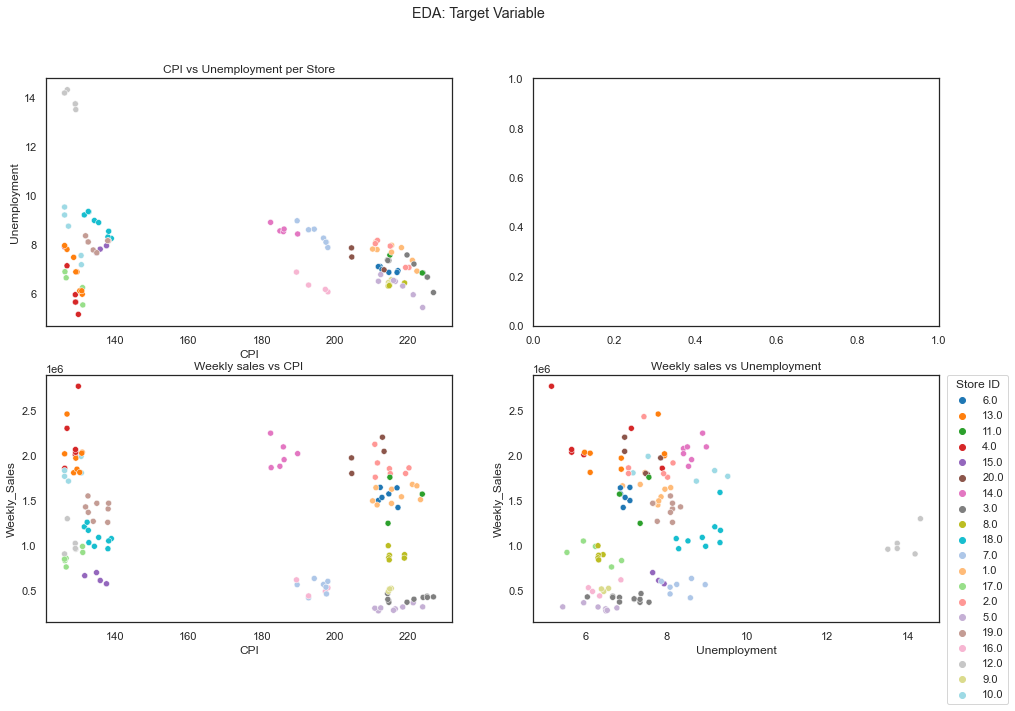

In [24]:
# Set axes for grid and figure size
figure, axes = plt.subplots(2, 2, figsize=(16,10))

# Figure 1: weekly sales vs month, all stores
fig1 = sns.scatterplot(x="CPI", y="Unemployment", hue="Store_str", palette=palette_20, data=data_reformat_df,legend=False, ax= axes[0,0])
fig1.set(title='CPI vs Unemployment per Store')

# Figure 2 : weekly sales vs month per store
fig2 = sns.scatterplot(x="CPI", y="Weekly_Sales", hue="Store_str", palette=palette_20, data=data_reformat_df,legend=False, ax= axes[1,0])
fig2.set(title = 'Weekly sales vs CPI')

# Figure 3 : weekly sales vs month per store
fig3 = sns.scatterplot(x="Unemployment", y="Weekly_Sales", hue="Store_str", palette=palette_20, data=data_reformat_df, ax= axes[1,1])
fig3.set(title = 'Weekly sales vs Unemployment')
fig3.legend(title="Store ID", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Export image in results
plt.suptitle("EDA: Target Variable")
plt.savefig('results/01-EDA_store_groups_CPI_unemployment.png', bbox_inches='tight')


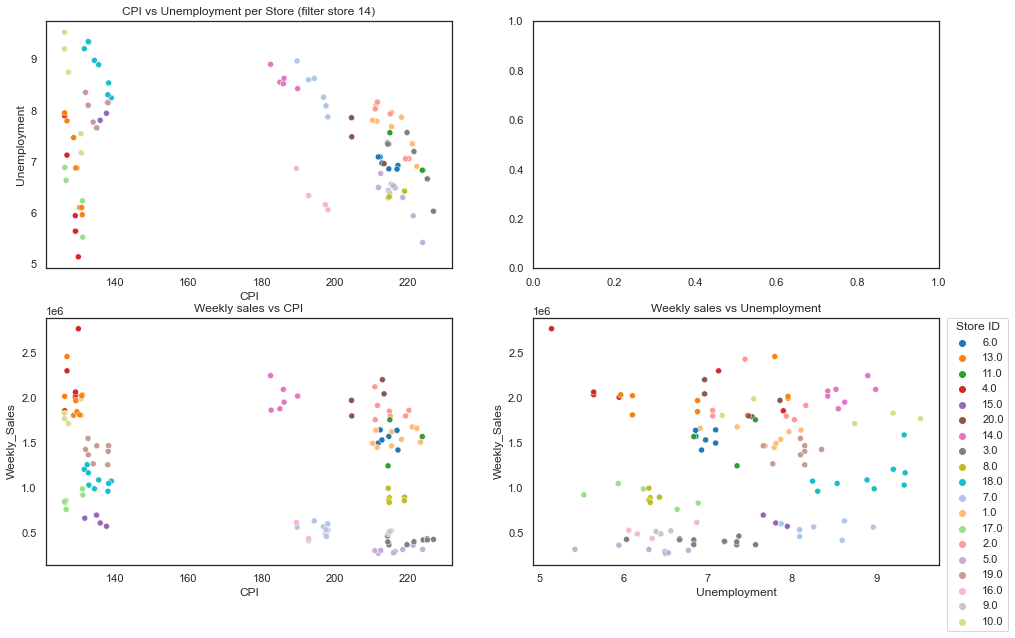

In [25]:
# Replot without Store 12, which comes out as an outlier: high unemployment rate yet low CPI so weekly sales not as low

# Filter dataframe
df_plot = data_reformat_df.copy()
df_plot_filt = df_plot[df_plot['Store']!=12]

# Set axes for grid and figure size
figure, axes = plt.subplots(2, 2, figsize=(16,10))

# Figure 1: weekly sales vs month, all stores
fig1 = sns.scatterplot(x="CPI", y="Unemployment", hue="Store_str", palette=palette_20[:19], data=df_plot_filt,legend=False, ax= axes[0,0])
fig1.set(title='CPI vs Unemployment per Store (filter store 14)')

# # Figure 2 : weekly sales vs month per store
fig2 = sns.scatterplot(x="CPI", y="Weekly_Sales", hue="Store_str", palette=palette_20[:19],data=df_plot_filt,legend=False, ax= axes[1,0])
fig2.set(title = 'Weekly sales vs CPI')

# # Figure 3 : weekly sales vs month per store
fig3 = sns.scatterplot(x="Unemployment", y="Weekly_Sales", hue="Store_str", palette=palette_20[:19], data=df_plot_filt, ax= axes[1,1])
fig3.set(title = 'Weekly sales vs Unemployment')
fig3.legend(title="Store ID", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## 5. Weekly sales in detail: per store, per year, per month

#### Store with most weekly sales entries

In [26]:
# Order by Store ID and month
data_reformat_df.sort_values(by=['Store'], inplace=True)

# Unique number of stores
print('There are {} unique stores and {} weekly sale entries in total'.format(data_reformat_df['Store'].nunique(),data_reformat_df['Store'].value_counts().sum() ))

# Which store has the most entries: print number of values per store (visualized in value distribution plot)
print('Number of weekly sale entries per store: order from highest to lowest number of entries')
data_reformat_df['Store'].value_counts().sort_values(ascending=False).rename_axis('Store').to_frame('counts')


There are 20 unique stores and 136 weekly sale entries in total
Number of weekly sale entries per store: order from highest to lowest number of entries


,counts
Store,
3.0,12
18.0,10
1.0,9
14.0,9
13.0,9
5.0,8
7.0,8
19.0,8
2.0,8


#### Weekly Sales per month, per store, per year

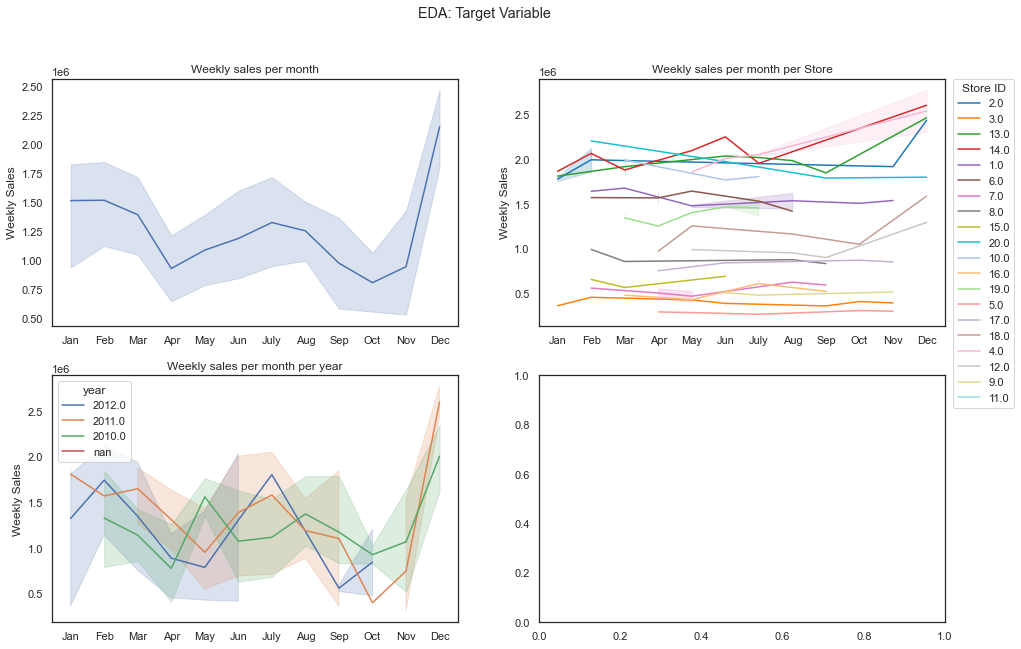

In [27]:
# Visualize scatterplot for clearer visualization of correlations

# Order dataframe by month for plotting
df_plot = data_reformat_df.copy()
df_plot = data_reformat_df.sort_values(by=['month', 'Store'])

# Convert year to string
df_plot['year'] = [str(Year) for Year in df_plot.year.tolist()]

# Set axes for grid and figure size
figure, axes = plt.subplots(2, 2, figsize=(16,10))


# Figure 1: weekly sales vs month, all stores
fig1 = sns.lineplot(data=df_plot, x="month_en", y="Weekly_Sales", sort=False, ax=axes[0,0])
fig1.set(title = 'Weekly sales per month' , xlabel='', ylabel='Weekly Sales')

# Figure 2 : weekly sales vs month per store
fig2 = sns.lineplot(data=df_plot, x="month_en", y="Weekly_Sales", hue='Store_str', palette=palette_20, ax=axes[0,1])
fig2.set(title = 'Weekly sales per month per Store' , xlabel='', ylabel='Weekly Sales')
fig2.legend(title="Store ID", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Figure 3 : weekly sales vs month per store
fig3 = sns.lineplot(data=df_plot, x="month_en", y="Weekly_Sales", hue='year', ax=axes[1,0])
fig3.set(title = 'Weekly sales per month per year' , xlabel='', ylabel='Weekly Sales')


# Export image in results
plt.suptitle("EDA: Target Variable")
plt.savefig('results/01-EDA_target_variable_distribution-permonthyear.png', bbox_inches='tight')

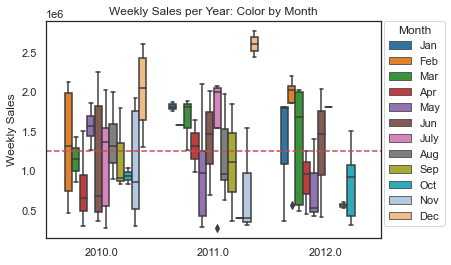

In [28]:
# Better visualize distribution of weekly sales per month per year: plot boxplot

# Order dataframe by month for plotting
df_plot = data_reformat_df.copy()
df_plot = data_reformat_df.sort_values(by=['month', 'Store'])

fig = sns.boxplot(x="year", y="Weekly_Sales", data=df_plot, hue="month_en", palette=palette_20)
fig.set(title="Weekly Sales per Year: Color by Month", xlabel='', ylabel='Weekly Sales') 

# place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0,title="Month")      

# Add line at mean of Weekly sales
mean_weekly_sales = round(data_reformat_df['Weekly_Sales'].mean(), 2)

plt.axhline(y=mean_weekly_sales, color='r', linestyle='dashed')

plt.show()

### Median Sales per month

In [29]:
group_df_agg_fn(data_reformat_df, group_col='month', col_eval='Weekly_Sales', aggfn='median', div_by=1e6, div=True)

median_Weekly_Sales (1.00e+06)


,median_Weekly_Sales
month,
12.0,2.367621
1.0,1.799520
2.0,1.751880
3.0,1.552248
7.0,1.540664
8.0,1.166118
6.0,1.156363
5.0,1.138719
4.0,0.961186


#### Median Sales per year

In [30]:
# Which year resulted in most weekly sales
group_df_agg_fn(data_reformat_df, group_col='year', col_eval='Weekly_Sales', aggfn='median', div_by=1e6, div=True)

median_Weekly_Sales (1.00e+06)


,median_Weekly_Sales
year,
2011.0,1.466047
2010.0,1.295605
2012.0,1.164583


#### Total Sales per store

In [31]:
group_df_agg_fn(data_reformat_df, group_col='Store_str', col_eval='Weekly_Sales', aggfn='sum', div_by=1e6, div=True)

sum_Weekly_Sales (1.00e+06)


,sum_Weekly_Sales
Store_str,
14.0,18.835906
13.0,17.975119
2.0,15.544269
1.0,14.062575
4.0,13.042554
18.0,11.404365
19.0,11.204922
20.0,9.811922
6.0,9.306741


### Median Sales per store

In [32]:
group_df_agg_fn(data_reformat_df, group_col='Store_str', col_eval='Weekly_Sales', aggfn='median', div_by=1e6, div=True)

median_Weekly_Sales (1.00e+06)


,median_Weekly_Sales
Store_str,
14.0,2.077256
4.0,2.051387
13.0,1.997398
20.0,1.973136
2.0,1.857482
10.0,1.806000
11.0,1.569608
6.0,1.552213
1.0,1.539484


## 6. EDA Conclusions  

- Basic data description  
    * There are **150 samples** and **8 variables**  
        * Categorical: *Holiday_Flag*  
        * Numerical: *Temperature, Fuel_Price, CPI, Unemployment, Weekly_Sales*   
        * Datetime: *Date*  
        * Unique: *Store*  
    * Missing values: 
        * 9% of missing values for target variables (Weekly sales; 14/150 values missing)  
        * The date and temperature variables contain highest percentage of missing values (12%)
    * Target variable:  
        * Kind of bimodal distribution, which could suggest peak sales due to certain times of the year  
        * No real extreme values found, so all values kept

<br>

- Variable exploration  
    * **Year** with **most sale entries**: The year with most weekly sale entries is **2010** (30% of entries) 
    * **Year** with **highest median sales**:  **2011** (year with lowest CPI - measure of inflation)
    * **Month** with **most sale entries**: The months with most sale entries are **May** and **June**, followed by February and July
    * **Months** with **highest sale**s: **December**, February and July 
    * **Store** with **most sale entries**: Stores **3** and **18**
    * **Store** with** highest median sales**: Stores **14**, **4** and **13**

<br>

- Variable relationships  
    * **Fuel** is **strongly correlated to year**, with distribution of values different between years. This could be useful for imputing missing year variables. May have to drop this variable due to collinearity during modeling.    
    * **CPI** and **unemployment** are **not** necessarily **very correlated** to **weekly sales per store**. This suggest that **store location may be important** as stores found in areas with overall higher incomes and job stability might not be as affected by higher CPI and/ or unemployment rate. 

<br>

- Pre-processed variables after EDA 
    * **Date**: converted string to **datetime** and **extracted date features** 
    * **Temperature**: conversion from Fahrenheit to **Celsius** degrees  
    * **Store** string ID: extra column of **string** store **ID**

<br>

- Pre-processing to be done for machine learning modeling  
    * **Outliers**:  
    May take out store 12 which came out as an outlier for CPI vs unemployment vs weekly sales (to test when evaluating model performance increase)    
    * **Imputing** missing values:  
        * Fuel price to impute missing year  
        * Temperature to impute missing quarter
        * Official USA holidays to impute holiday flag
    * **Feature Engineering**:  
        * Categorise temperature, CPI and unemployment into high and low  
        * Define a group for stores based on their distribution on CPI, unemployment and weekly sales  
 